## $q$ Value calculations in breast cancer set

First we retrieve the breast cancer RNAseq data as well as the clinical classification of the sets from cbioportal.org. The code for the retrieval of this data set is not important for the understanding of the analysis, but the code is kept for completness. Execute the code and proceed to next step.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import urllib.request
import tarfile
import gzip
import requests

def track_dl(url,tar):
    response = requests.get(url, stream=True)
    with open(tar, "wb") as handle:
        for data in response.iter_content():
            handle.write(data)

def get_tar(url,path):
    try:
        tf = tarfile.open(path)
    except:
        track_dl(url, path)
        tf = tarfile.open(path)
    return tf

def get_expression_data(path,url,file):
    df = get_data(path,url,file)
    df.dropna(axis=0, how='any', inplace=True)
    df.set_index('Hugo_Symbol', inplace=True)
    df.drop(columns=['Unnamed: 0', 'Entrez_Gene_Id'], inplace=True)
    #df.drop(columns=['Entrez_Gene_Id'], inplace=True)
    df = df.reindex(sorted(df.columns), axis=1)
    return df

def get_clinical_data(path,url,file):
    df = get_data(path,url,file).T
    df.columns = df.iloc[2]
    df.drop(columns=["A unique sample identifier.","STRING","1","SAMPLE_ID"], inplace=True)
#    df.drop(columns=["STRING","1"], inplace=True)
    df.drop(index=["Unnamed: 0","#Patient Identifier","Sample Identifier","Other Sample ID"], inplace=True)
    df = df.reindex(sorted(df.columns), axis=1)
    return df

def get_data(path,url,file):
    try:
        df = pd.read_csv(gzip.open(path,'rb'), sep="\t")
    except:
        urllib.request.urlretrieve(url, "my.tar.gz")
        tf = get_tar(url,"my.tar.gz")
        tf.extract(file)
        df = pd.read_csv(file, sep="\t")
        df.to_csv(gzip.open(path,'wb'), sep="\t")
    return df

brca = get_expression_data("../../data/brca.tsv.gz", 'http://download.cbioportal.org/brca_tcga_pub2015.tar.gz',"data_RNA_Seq_v2_expression_median.txt")
brca_clin = get_clinical_data("../../data/brca_clin.tsv.gz", 'http://download.cbioportal.org/brca_tcga_pub2015.tar.gz',"data_clinical_sample.txt")


Before any further analysis we clean our data. This includes removal of genes where no transcripts were found for any of the samples , i.e. their values are either [NaN](https://en.wikipedia.org/wiki/NaN) or zero. 

The data is also log transformed. It is generally assumed that expression values follow a log-normal distribution, and hence the log transformation implies that the new values follow a nomal distribution.

In [2]:
brca.dropna(axis=0, how='any', inplace=True)
brca = brca.loc[~(brca<=0.0).any(axis=1)]
brca = pd.DataFrame(data=np.log2(brca),index=brca.index,columns=brca.columns)

### Differential expression analysis

Here we would like to compare so called tripple negative cancers with other cancers. A breast cancer is triple negative when it does not express either [Progesterone receptors](https://en.wikipedia.org/wiki/Progesterone_receptor), [Estrogen receptors](https://en.wikipedia.org/wiki/Estrogen_receptor) or [Epidermal growth factor receptor 2](https://en.wikipedia.org/wiki/HER2/neu). Such cancers are known to behave different than other cancers, and are not amendable to regular [hormonal theraphies](https://en.wikipedia.org/wiki/Hormonal_therapy_(oncology)).

We first create a vector of booleans, that track which cancers that are tripple negative.

In [3]:
brca_clin.loc["3N"]= (brca_clin.loc["PR status by ihc"]=="Negative") & (brca_clin.loc["ER Status By IHC"]=="Negative") & (brca_clin.loc["IHC-HER2"]=="Negative")
tripple_negative_bool = (brca_clin.loc["3N"] == True)

Next we calculate significance of the difference between tripple negaive cancers and other cancers.

In [4]:
from scipy.stats import ttest_ind

def get_pvalue_two_groups(row):
    return (ttest_ind(row[tripple_negative_bool],row[~tripple_negative_bool],equal_var=False)[1])

pvalues = brca.apply(get_pvalue_two_groups,axis=1).to_frame(name="p")


When plotting the $p$ value distribution below, we see an enrichment of low p values.

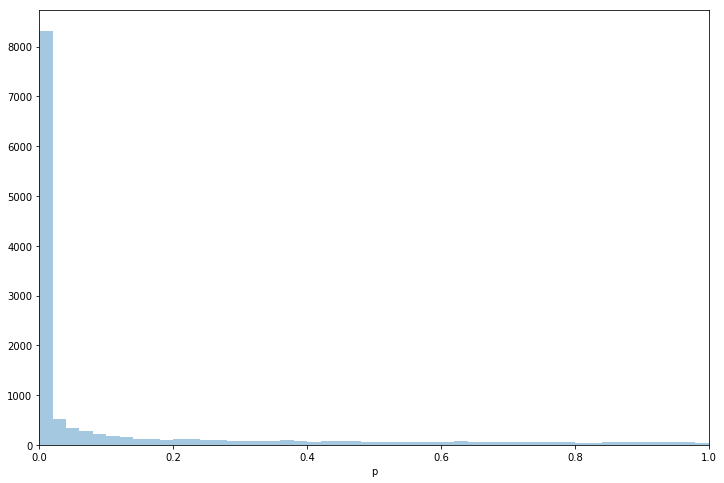

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.distplot(pvalues["p"],kde=False)
plt.xlim(0,1.0);

### $q$ value esitmation
We define a function for the palculation of $\pi_0$. Here we use a different method than the one described in Storey&Tibshirani. The details of this method, known as the *bootstrap method*, are given in [Storey 2002](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/1467-9868.00346)

In [6]:
import numpy as np
import numpy.random as npr

def bootstrap(invec):
    idx = npr.randint(0, len(invec), len(invec))
    return [invec[i] for i in idx]

def estimatePi0(p, numBoot=100, numLambda=100, maxLambda=0.95):
    p.sort()
    n=len(p)
    lambdas=np.linspace(maxLambda/numLambda,maxLambda,numLambda)
    Wls=np.array([n-np.argmax(p>=l) for l in lambdas])
    pi0s=np.array([Wls[i] / (n * (1 - lambdas[i])) for i in range(numLambda)])
    minPi0=np.min(pi0s)
    mse = np.zeros(numLambda)
    for boot in range(numBoot):
        pBoot = bootstrap(p)
        pBoot.sort()
        WlsBoot =np.array([n-np.argmax(pBoot>=l) for l in lambdas])
        pi0sBoot =np.array([WlsBoot[i] / (n *(1 - lambdas[i])) for i in range(numLambda)])
        mse = mse + np.square(pi0sBoot-minPi0)
    minIx = np.argmin(mse)
    return pi0s[minIx]

We subsequently use Storey&Tibshirani to calculate first calculate 
$$ 
\hat{\rm FDR}(t) = \frac{\pi_0mp}{|\{p_i\le t\}|}
$$
and then smooth the $\rm FDR(t)$ estimates as $$\hat{q}(p_i)=min_{t \ge p_i}\hat{\rm FDR}(t)$$

In [7]:
def qvalues(pvalues):
    m = pvalues.shape[0] # The number of p-values
    pvalues.sort_values("p",inplace=True) # sort the pvalues in acending order
    pi0 = estimatePi0(list(pvalues["p"].values))
    print("pi_0 estimated to " + str(pi0))
    
    # calculate a FDR(t) as in Storey & Tibshirani
    num_p = 0.0
    for ix in pvalues.index:
        num_p += 1.0
        fdr = pi0*pvalues.loc[ix,"p"]*m/num_p
        pvalues.loc[ix,"q"] = fdr
    
    # calculate a q(p) as the minimal FDR(t)
    old_q=1.0
    for ix in reversed(list(pvalues.index)):
        q = min(old_q,pvalues.loc[ix,"q"])
        old_q = q
        pvalues.loc[ix,"q"] = q
    return pvalues

In [8]:
qv = qvalues(pvalues)

pi_0 estimated to 0.193835872948997


We note a very low $pi_0$ indicating that about 80\% of all genes are differentially expressed in the tripple negative cancers. This is maybe not only reflects the different biology of tripple negative cancers, but might also relate to differencees in sample handlig or normalization of data.

A plot of the number of differentially expressed genes as a function of $q$ value gives the same message.

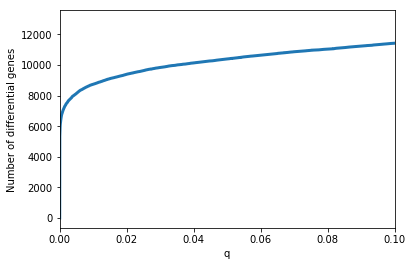

In [9]:
sns.lineplot(pvalues["q"],list(range(pvalues.shape[0])),ci=None,lw=3)
plt.xlim(0,0.1);
plt.ylim();
plt.ylabel("Number of differential genes");

We can list the differntial genes, in descending order of significance.

In [10]:
qv

,p,q
Hugo_Symbol,,
NAT1,3.104964e-45,7.780762e-42
TBC1D9,2.162932e-43,2.475169e-40
ESR1,2.963198e-43,2.475169e-40
ARMT1,5.785445e-43,3.624451e-40
SLC16A6,7.397218e-43,3.707353e-40
SLC39A6,3.470887e-40,1.449622e-37
CDCA7,4.285926e-40,1.534307e-37
RABEP1,6.481488e-40,2.030253e-37
CCDC170,2.844479e-38,7.920010e-36


We end by saving our $q$ values for future use.

In [11]:
qv["q"].to_frame().to_csv("qvalues.tsv",sep="\t")